In [19]:
PATH = "."

# Fall 2022: DS-GA 1011 NLP with Representation Learning
## Homework 2
## Part 1: Bag-of-Words based Natural Language Inference (30 pts)

In this assignment, you will train a Bag-of-Words encoder to tackle the Stanford Natural Language Inference (SNLI) task.

We have 5 coding questions and 3 written questions. Some coding functions are provided for your reference, but you are welcome to change and write your own functions. You should deliver your training and validation results in written questions.

In [20]:
# Import required packages
import os
import numpy as np
import pickle as pkl

import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from typing import List
from matplotlib import pyplot as plt
import pandas as pd

In [21]:
# save index 0 for unk and 1 for pad
global PAD_IDX, UNK_IDX
UNK_IDX = 0
PAD_IDX = 1
torch.manual_seed(0)

---
### 1 Dataset (6 pts)
#### Data Processing

In [22]:
# Read data
# tokenized data provided or you can tokenize data by your self
folder = os.path.join(PATH, 'data_after_process')

prem_data_tokens_train = pkl.load(open(os.path.join(folder, 'hypo_data_tokens_train.p'), "rb"))
hypo_data_tokens_train = pkl.load(open(os.path.join(folder, 'prem_data_tokens_train.p'), "rb"))

prem_data_tokens_val = pkl.load(open(os.path.join(folder, 'hypo_data_tokens_val.p'), "rb"))
hypo_data_tokens_val = pkl.load(open(os.path.join(folder, 'prem_data_tokens_val.p'), "rb"))

label_index_train = pkl.load(open(os.path.join(folder, 'label_index_train.p'), "rb"))
label_index_val = pkl.load(open(os.path.join(folder, 'label_index_val.p'), "rb"))

**Coding 1: finish `build_vocab` function** (2 pts)


In [23]:
def build_vocab(hypo_tokens: List[List[str]], prem_tokens: List[List[str]], max_vocab_size=10000):
    # TODO:
    # build vocab
    # returns: 
    # - id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # - token2id: dictionary where keys represent tokens and corresponding values represent indices
    
    word_bag = dict()
    def add_to_bag(token_list):
        for sentence in token_list:
            for token in sentence:
                word_bag[token] = word_bag.get(token, 0) + 1

    add_to_bag(hypo_tokens)
    add_to_bag(prem_tokens)
    
    # some pruning to use `max_vocab_size`
    pruned_word_bag = sorted(word_bag.keys(), key=word_bag.get, reverse=True)[:max_vocab_size]

    id2token = list(pruned_word_bag)
    id2token.insert(UNK_IDX, "<unk>")
    id2token.insert(PAD_IDX, "<pad>")
    
    token2id = dict()
    for id, token in enumerate(id2token):
        token2id[token] = id

    

    return token2id, id2token

**Coding 2: finish `token2index` function** (2 pts)

In [24]:
def token2index(tokens_data: List[List[str]], token2id: dict):
    # TODO:
    # convert token to id in the dataset
    # returns:
    # - indices_data: return list of index_list (index list for each sentence)
    def encode(sentence: List[str]):
        return [token2id[token] if token in token2id else UNK_IDX for token in sentence]

    return [encode(sentence) for sentence in tokens_data]

In [25]:
max_vocab_size=10000
token2id, id2token = build_vocab(hypo_data_tokens_train, prem_data_tokens_train, max_vocab_size=max_vocab_size)

In [26]:
hypo_data_indices_train = token2index(hypo_data_tokens_train, token2id)
prem_data_indices_train = token2index(prem_data_tokens_train, token2id)
hypo_data_indices_val = token2index(hypo_data_tokens_val, token2id)
prem_data_indices_val= token2index(prem_data_tokens_val, token2id)  

#### DataLoader

**Coding 3: finish DataLoader** (2 pts)

In [27]:
def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    hypo_list = []
    len_hypo_list = []
    prem_list = []
    len_prem_list = []
    label_list = []

    for datum in batch:
        label_list.append(datum[4])
        len_hypo_list.append(datum[1])
        len_prem_list.append(datum[3])
    # padding
    for datum in batch:
        # hypo
        padded_vec = np.pad(np.array(datum[0]), pad_width=((0,max_sentence_length-datum[1])), mode="constant", constant_values=PAD_IDX)
        hypo_list.append(padded_vec)
        # prem
        padded_vec = np.pad(np.array(datum[2]), pad_width=((0,max_sentence_length-datum[3])), mode="constant", constant_values=PAD_IDX)
        prem_list.append(padded_vec)
    return [torch.from_numpy(np.array(hypo_list)), torch.LongTensor(len_hypo_list), 
            torch.from_numpy(np.array(prem_list)), torch.LongTensor(len_prem_list), torch.LongTensor(label_list)]

In [28]:
class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, hypo_list, prem_list, target_list, max_sentence_length):
        """
        @param hypo_list: list of hypo tokens
        @param prem_list: list of prem tokens
        @param target_list: list of newsgroup targets
        @param max_sentence_length: fixed length of all sentence
        """
        self.hypo_list = hypo_list
        self.prem_list = prem_list
        self.target_list = target_list
        self.max_sentence_length = max_sentence_length
        assert (len(self.hypo_list) == len(self.target_list))
        assert (len(self.prem_list) == len(self.target_list))
        
    def __len__(self):
        return len(self.hypo_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        token_hypo_idx = self.hypo_list[key][:self.max_sentence_length]
        token_prem_idx = self.prem_list[key][:self.max_sentence_length]
        label = self.target_list[key]
        return [token_hypo_idx, len(token_hypo_idx), token_prem_idx, len(token_prem_idx), label]

In [29]:
max_sentence_length = 20

train_dataset = NewsGroupDataset(hypo_data_indices_train, prem_data_indices_train, label_index_train, max_sentence_length)
val_dataset = NewsGroupDataset(hypo_data_indices_val, prem_data_indices_val, label_index_val,max_sentence_length)

In [30]:
# TODO:
# finish DataLoader
BATCH_SIZE = 1024
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=newsgroup_collate_func)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=newsgroup_collate_func)

---
### 2 Model (8 pts)

We will use a BoW encoder to map each string of text (hypothesis and premise) to a fixed-dimension vector representation. At this point, we have one vector representation corresponding to hypothesis and one for premise. 

We will interact the two representations and perform classification on this. For combining the two vector representations, you should try at least methods: concatenate, sum, and element-wise product. 

Once we’ve the combined representation, we will to do a 3-class classification Logistic Model on this input vector. 

**Coding 4: finish `LogisticsModelPytorch` Class** (code from the labs may be helpful). (8 pts)

In [31]:
class LogisticsModelPytorch(nn.Module):

    def __init__(self, vocab_size, emb_dim, n_out, reduce):
        """
        @param vocab_size: size of the vocabulary.
        @param emb_dim: size of the word embedding.
        @param n_out: size of the class.
        @param reduce: interaction type: [sum, concat, element-wise].
        """
        
        super(LogisticsModelPytorch, self).__init__()
        
        # TODO: 
        # 1. Embedding
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_dim, padding_idx = PAD_IDX)
        # 2. Linear Layers
        if reduce == 'concat':
            self.linear = nn.Linear(2*emb_dim, n_out)
        else:
            self.linear = nn.Linear(emb_dim, n_out)
        

    def forward(self, data_hypo, length_hypo, data_prem, length_prem):
        """
            @param data_hypo: matrix of size (batch_size, max_sentence_length). Each row in data represents a
            review that is represented using n-gram index. Note that they are padded to have same length.
            @param length_hypo: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in data_hypo.
            @param data_prem: matrix of size (batch_size, max_sentence_length).
            @param length_hypo: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
                length of each sentences in data_prem.
            """
        
        # TODO:
        # word embedding
        embedded_hypothesis = self.embedding(data_hypo) # [batch, len_1, embed_dim]
        # bagged_embedded_hypothesis = embedded_hypothesis.mean(dim=1)
        
        bagged_embedded_hypothesis = torch.sum(embedded_hypothesis, dim=1) / torch.unsqueeze(length_hypo, dim=1)
        
        embedded_premise = self.embedding(data_prem)    # [batch, len_2, embed_dim]
        # bagged_embedded_premise = embedded_premise.mean(dim=1)
        
        bagged_embedded_premise = torch.sum(embedded_premise, dim=1) / torch.unsqueeze(length_prem, dim=1)

        # combine to sentence
    
        # interaction
        # 1. sum
        # 2. Hadamard (element-wise) product
        # 3. concat (This will change embedding dimension, 2 times as many as before)
        if reduce == 'concat':
            resultant_encoding = torch.concat([bagged_embedded_hypothesis, bagged_embedded_premise], dim=1)
        if reduce == 'sum':
            resultant_encoding = bagged_embedded_hypothesis + bagged_embedded_premise
        if reduce == 'hadamard':
            resultant_encoding = bagged_embedded_hypothesis * bagged_embedded_premise
        
        # hidden layers 
        logit = self.linear(resultant_encoding)
        return F.log_softmax(logit, dim=1)

---
### 3 Training and Validation (16 pts)

Train your model in different settings. 

Perform tuning over at least two of the following hyperparameters:
1. vocab size in `build_vocab` function
2. embedding size in `LogisticsModelPytorch` class
3. SGD vs Adam
4. learning rate in training

**For interaction type `reduce`, you need to try at least two methods: sum, element-wise product, and concatenation.** 


In [32]:
# training:
def train_util(model, criterion, optimizer, train_loader):
    
    running_loss = 0.0
    correct_samples = 0
    total_samples = 0
    batch_loss = list()
    batch_acc = list()

    for hypo_idx, hypo_idx_len, prem_idx, prem_idx_len, label in train_loader:
        
        optimizer.zero_grad()
        output = model(hypo_idx, hypo_idx_len, prem_idx, prem_idx_len)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        # batch level info
        output_categories = output.argmax(dim=1)
        batch_size = label.size()[0]
        correct_samples_in_batch = (label == output_categories).sum().item()
        batch_loss.append(loss.item())
        batch_acc.append(correct_samples_in_batch/batch_size)
        
        # epoch level info
        running_loss += loss
        total_samples += label.size()[0]
        correct_samples += (label == output_categories).sum().item()

    running_loss /= len(train_loader)
    accuracy = correct_samples/total_samples

    return running_loss.item(), accuracy, batch_loss, batch_acc

def validation_util(model, criterion, val_loader):
    running_loss = 0.0
    correct_samples = 0
    total_samples = 0
    batch_loss = list()
    batch_acc = list()

    with torch.no_grad():

        for hypo_idx, hypo_idx_len, prem_idx, prem_idx_len, label in val_loader:

            output = model(hypo_idx, hypo_idx_len, prem_idx, prem_idx_len)
            loss = criterion(output, label)
            
            # batch level info
            output_categories = output.argmax(dim=1)
            batch_size = label.size()[0]
            correct_samples_in_batches = (label == output_categories).sum().item()
            batch_loss.append(loss.item())
            batch_acc.append(correct_samples_in_batches/batch_size)
            
            # epoch level info
            running_loss += loss
            total_samples += batch_size
            correct_samples += correct_samples_in_batches

        running_loss /= len(val_loader)
        accuracy = correct_samples/total_samples

    return running_loss.item(), accuracy, batch_loss, batch_acc

In [33]:
def train(model, criterion, optimizer, num_epochs, PATH):
    
    train_losses = [] # record training loss after every epoch
    val_losses = [] # record validation loss after every epoch
    train_accs = [] # record training accuracy after every epoch
    val_accs = [] # record validation accuracy after every epoch

    train_losses_batch = [] # record training loss after every batch
    val_losses_batch = [] # record validation loss after every batch
    train_accs_batch = [] # record training accuracy after every batch
    val_accs_batch = [] # record validation accuracy after every batch
    
    for epoch in range(num_epochs):

        train_loss, train_accuracy, train_batch_loss, train_batch_acc = train_util(model, criterion, optimizer, train_loader)
        val_loss, val_accuracy, val_batch_loss, val_batch_acc = validation_util(model, criterion, val_loader)
        
        # logging
        print(f"Epoch {epoch}:\tTrain loss: {train_loss}\tTrain accuracy: {train_accuracy}\t\
            Valid loss: {val_loss}\tValid accuracy: {val_accuracy}")
        
        # save if a better model is obtained
        if len(val_losses) == 0 or val_loss < val_losses[-1]:
            torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)
        
        # save epoch results
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
        
        # save batch results
        train_losses_batch.append(train_batch_loss)
        val_losses_batch.append(val_batch_loss)
        train_accs_batch.append(train_batch_acc)
        val_accs_batch.append(val_batch_acc)
        
    return train_losses, val_losses, train_accs, val_accs



**Coding 5: finish training and validation** (4 pts)

The following incomplete code can get you started on your train loop. Feel free to modify the function signature to pass any arguments needed for the training.

#### Performance variation based on hyper-parameter values

**Written 1:** (4 pts)
- For each mode of hyperparameter tuning (vocab size, embedding size, learning rate, reduce), report the training and validation losses and accuracies (in plotted curves). 
- Discuss the implications of each hyperparameter tuned.

Take the figure below as an example.

<!-- <img src="example.png" alt="drawing" style="width:400px;"/> -->
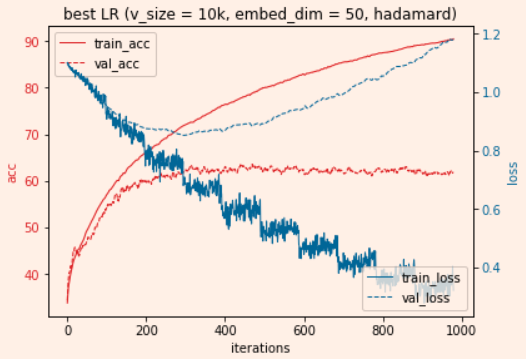

The following function may be useful to you to accomplish this, but you are also welcome to modify it or write your own plotting code.

In [34]:
def plot_over_training(per_epoch_metrics, title):
    """Utility function to plot train/val accuracies and losses.

    @param per_epoch_metrics: a dictionary of lists, where each list represents a metric over the
      course of training.
    @param title_name: String to show on the plot title.
    """
    t = np.arange(0, len(per_epoch_metrics['train_accs']))
    train_acc = per_epoch_metrics['train_accs']
    val_acc = per_epoch_metrics['val_accs']
    train_loss = per_epoch_metrics['train_losses']
    val_loss = per_epoch_metrics['val_losses']

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('acc', color=color)
    ax1.plot(t, train_acc, color=color, linewidth=1, label = 'train_acc')
    ax1.plot(t, val_acc, color=color, linestyle='dashed', linewidth=1, label = 'val_acc')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    ax2 = ax1.twinx() 

    color = 'tab:blue'
    ax2.set_ylabel('loss', color=color)  # we already handled the x-label with ax1
    ax2.plot(t, train_loss, color=color, linewidth=1, label = 'train_loss')
    ax2.plot(t, val_loss, color=color, linestyle='dashed', linewidth=1, label = 'val_loss')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='lower right')
    fig.tight_layout() 
    plt.title(title)

    fig_path = os.path.join(PATH, '../results/part1/images', f"{title}.png")
    plt.savefig(fig_path)
    plt.show()


### Call trainer

In [35]:
def train_wrapper(params: dict):
    
    reduce = params["reduce"]
    learning_rate = params["learning_rate"]
    emb_dim = params["emb_dim"]
    num_epochs = params["num_epochs"]
    
    title = f"{reduce}_{emb_dim}"
    print(title)

    model = LogisticsModelPytorch(
        vocab_size=len(id2token),
        emb_dim=emb_dim,
        n_out=len(set(label_index_train)),
        reduce=reduce)

    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model_path = os.path.join(PATH, '../results/part1/models', f"{title}.pt")
    train_losses, val_losses, train_accs, val_accs = train(model, criterion, optimizer, num_epochs, model_path)
    
    per_epoch_metrics = {
        'train_accs': train_accs,
        'val_accs': val_accs,
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    return model, per_epoch_metrics, title

### Experiments and hyoerparameters config

hadamard_30
Epoch 0:	Train loss: 0.9997764825820923	Train accuracy: 0.49411	            Valid loss: 0.8958548307418823	Valid accuracy: 0.579
Epoch 1:	Train loss: 0.8117873668670654	Train accuracy: 0.63879	            Valid loss: 0.8392713069915771	Valid accuracy: 0.628
Epoch 2:	Train loss: 0.6876042485237122	Train accuracy: 0.7086	            Valid loss: 0.843076229095459	Valid accuracy: 0.624
Epoch 3:	Train loss: 0.5930481553077698	Train accuracy: 0.75692	            Valid loss: 0.8711799383163452	Valid accuracy: 0.631
Epoch 4:	Train loss: 0.516865074634552	Train accuracy: 0.79413	            Valid loss: 0.914701521396637	Valid accuracy: 0.64
Epoch 5:	Train loss: 0.453842431306839	Train accuracy: 0.82479	            Valid loss: 0.9955120086669922	Valid accuracy: 0.641
Epoch 6:	Train loss: 0.402245432138443	Train accuracy: 0.84721	            Valid loss: 1.0534874200820923	Valid accuracy: 0.637
Epoch 7:	Train loss: 0.3568529784679413	Train accuracy: 0.86686	            Valid loss: 1.16

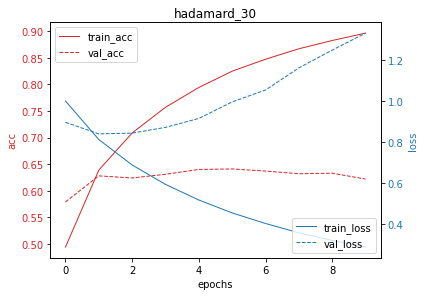

hadamard_40
Epoch 0:	Train loss: 0.9991557002067566	Train accuracy: 0.49877	            Valid loss: 0.9036633968353271	Valid accuracy: 0.578
Epoch 1:	Train loss: 0.796208381652832	Train accuracy: 0.64923	            Valid loss: 0.8577765226364136	Valid accuracy: 0.623
Epoch 2:	Train loss: 0.6591136455535889	Train accuracy: 0.72418	            Valid loss: 0.8828313946723938	Valid accuracy: 0.631
Epoch 3:	Train loss: 0.5492578744888306	Train accuracy: 0.7806	            Valid loss: 0.9602621793746948	Valid accuracy: 0.625
Epoch 4:	Train loss: 0.45983490347862244	Train accuracy: 0.82151	            Valid loss: 1.0408964157104492	Valid accuracy: 0.639
Epoch 5:	Train loss: 0.38658303022384644	Train accuracy: 0.85492	            Valid loss: 1.1469125747680664	Valid accuracy: 0.627
Epoch 6:	Train loss: 0.32617610692977905	Train accuracy: 0.8823	            Valid loss: 1.271419644355774	Valid accuracy: 0.601
Epoch 7:	Train loss: 0.2778555154800415	Train accuracy: 0.90277	            Valid loss

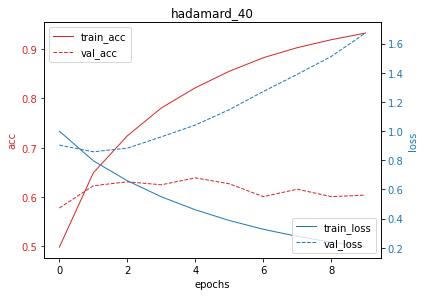

hadamard_50
Epoch 0:	Train loss: 0.9885844588279724	Train accuracy: 0.50467	            Valid loss: 0.8903412222862244	Valid accuracy: 0.607
Epoch 1:	Train loss: 0.7789753675460815	Train accuracy: 0.66154	            Valid loss: 0.8501743674278259	Valid accuracy: 0.623
Epoch 2:	Train loss: 0.6339933276176453	Train accuracy: 0.73879	            Valid loss: 0.8752800226211548	Valid accuracy: 0.629
Epoch 3:	Train loss: 0.5166622996330261	Train accuracy: 0.79644	            Valid loss: 0.9386029243469238	Valid accuracy: 0.629
Epoch 4:	Train loss: 0.42138001322746277	Train accuracy: 0.83976	            Valid loss: 1.0397717952728271	Valid accuracy: 0.632
Epoch 5:	Train loss: 0.3432474434375763	Train accuracy: 0.87404	            Valid loss: 1.1348567008972168	Valid accuracy: 0.625
Epoch 6:	Train loss: 0.2822663187980652	Train accuracy: 0.89985	            Valid loss: 1.280116319656372	Valid accuracy: 0.606
Epoch 7:	Train loss: 0.23218044638633728	Train accuracy: 0.92079	            Valid lo

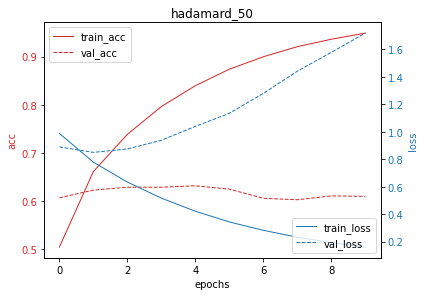

hadamard_60
Epoch 0:	Train loss: 0.984266459941864	Train accuracy: 0.51106	            Valid loss: 0.8822285532951355	Valid accuracy: 0.589
Epoch 1:	Train loss: 0.7675395607948303	Train accuracy: 0.6659	            Valid loss: 0.8294506669044495	Valid accuracy: 0.632
Epoch 2:	Train loss: 0.6126222610473633	Train accuracy: 0.74926	            Valid loss: 0.849797785282135	Valid accuracy: 0.641
Epoch 3:	Train loss: 0.4883520305156708	Train accuracy: 0.81019	            Valid loss: 0.9235076308250427	Valid accuracy: 0.643
Epoch 4:	Train loss: 0.3867337703704834	Train accuracy: 0.8551	            Valid loss: 1.0138589143753052	Valid accuracy: 0.631
Epoch 5:	Train loss: 0.3065784275531769	Train accuracy: 0.88986	            Valid loss: 1.1408225297927856	Valid accuracy: 0.622
Epoch 6:	Train loss: 0.24473567306995392	Train accuracy: 0.91524	            Valid loss: 1.248114824295044	Valid accuracy: 0.632
Epoch 7:	Train loss: 0.195520281791687	Train accuracy: 0.93517	            Valid loss: 1.

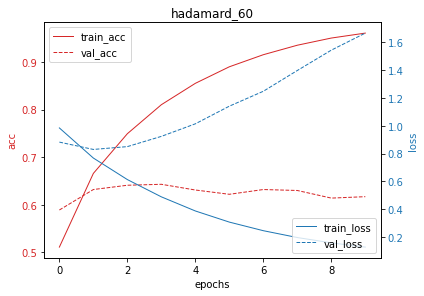

sum_30
Epoch 0:	Train loss: 1.0123426914215088	Train accuracy: 0.49241	            Valid loss: 0.934186577796936	Valid accuracy: 0.577
Epoch 1:	Train loss: 0.911210298538208	Train accuracy: 0.57905	            Valid loss: 0.9306898713111877	Valid accuracy: 0.573
Epoch 2:	Train loss: 0.8790931105613708	Train accuracy: 0.59957	            Valid loss: 0.9377102851867676	Valid accuracy: 0.559
Epoch 3:	Train loss: 0.8628994822502136	Train accuracy: 0.60704	            Valid loss: 0.9456314444541931	Valid accuracy: 0.568
Epoch 4:	Train loss: 0.8532981276512146	Train accuracy: 0.61511	            Valid loss: 0.9482909440994263	Valid accuracy: 0.569
Epoch 5:	Train loss: 0.8455578684806824	Train accuracy: 0.61691	            Valid loss: 0.9607642889022827	Valid accuracy: 0.572
Epoch 6:	Train loss: 0.839899480342865	Train accuracy: 0.61949	            Valid loss: 0.9640985131263733	Valid accuracy: 0.572
Epoch 7:	Train loss: 0.8357648849487305	Train accuracy: 0.62194	            Valid loss: 0.964

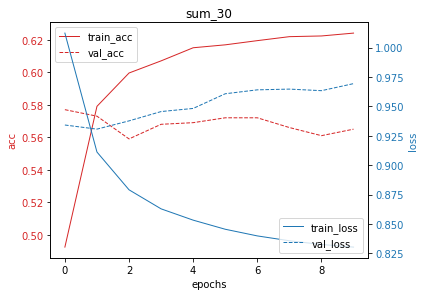

sum_40
Epoch 0:	Train loss: 1.0060263872146606	Train accuracy: 0.49633	            Valid loss: 0.9408876895904541	Valid accuracy: 0.586
Epoch 1:	Train loss: 0.9101366400718689	Train accuracy: 0.58132	            Valid loss: 0.9307330846786499	Valid accuracy: 0.584
Epoch 2:	Train loss: 0.8799137473106384	Train accuracy: 0.59943	            Valid loss: 0.9421163201332092	Valid accuracy: 0.579
Epoch 3:	Train loss: 0.8638306260108948	Train accuracy: 0.60825	            Valid loss: 0.94242924451828	Valid accuracy: 0.578
Epoch 4:	Train loss: 0.8533315062522888	Train accuracy: 0.61349	            Valid loss: 0.9490369558334351	Valid accuracy: 0.579
Epoch 5:	Train loss: 0.8461599349975586	Train accuracy: 0.61709	            Valid loss: 0.9581721425056458	Valid accuracy: 0.565
Epoch 6:	Train loss: 0.8412507772445679	Train accuracy: 0.61937	            Valid loss: 0.9593213796615601	Valid accuracy: 0.56
Epoch 7:	Train loss: 0.8376549482345581	Train accuracy: 0.62002	            Valid loss: 0.961

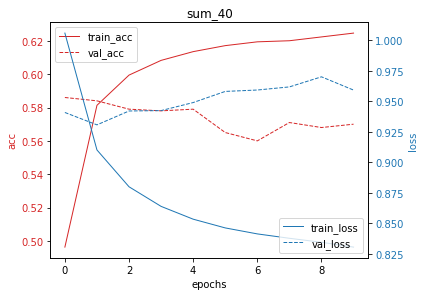

sum_50
Epoch 0:	Train loss: 1.003238320350647	Train accuracy: 0.50198	            Valid loss: 0.9427075982093811	Valid accuracy: 0.546
Epoch 1:	Train loss: 0.9087583422660828	Train accuracy: 0.58093	            Valid loss: 0.938017725944519	Valid accuracy: 0.557
Epoch 2:	Train loss: 0.8804216384887695	Train accuracy: 0.59828	            Valid loss: 0.9456027150154114	Valid accuracy: 0.582
Epoch 3:	Train loss: 0.8630195260047913	Train accuracy: 0.60793	            Valid loss: 0.9500133991241455	Valid accuracy: 0.564
Epoch 4:	Train loss: 0.8544456958770752	Train accuracy: 0.61228	            Valid loss: 0.9595984816551208	Valid accuracy: 0.567
Epoch 5:	Train loss: 0.8477787971496582	Train accuracy: 0.61674	            Valid loss: 0.9599977135658264	Valid accuracy: 0.555
Epoch 6:	Train loss: 0.8423040509223938	Train accuracy: 0.61828	            Valid loss: 0.9569016695022583	Valid accuracy: 0.574
Epoch 7:	Train loss: 0.8377729654312134	Train accuracy: 0.62027	            Valid loss: 0.96

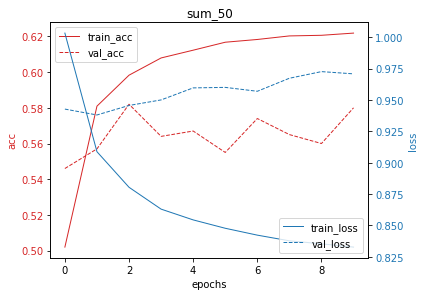

sum_60
Epoch 0:	Train loss: 0.9972226023674011	Train accuracy: 0.50518	            Valid loss: 0.9386221766471863	Valid accuracy: 0.572
Epoch 1:	Train loss: 0.9074857831001282	Train accuracy: 0.58086	            Valid loss: 0.9458523988723755	Valid accuracy: 0.571
Epoch 2:	Train loss: 0.8794237971305847	Train accuracy: 0.5981	            Valid loss: 0.9472891092300415	Valid accuracy: 0.567
Epoch 3:	Train loss: 0.8643935918807983	Train accuracy: 0.60747	            Valid loss: 0.9450498819351196	Valid accuracy: 0.568
Epoch 4:	Train loss: 0.8539572954177856	Train accuracy: 0.61186	            Valid loss: 0.9514556527137756	Valid accuracy: 0.571
Epoch 5:	Train loss: 0.8489359617233276	Train accuracy: 0.61535	            Valid loss: 0.9593133926391602	Valid accuracy: 0.567
Epoch 6:	Train loss: 0.8425765037536621	Train accuracy: 0.61681	            Valid loss: 0.9587021470069885	Valid accuracy: 0.568
Epoch 7:	Train loss: 0.8387300372123718	Train accuracy: 0.61949	            Valid loss: 0.9

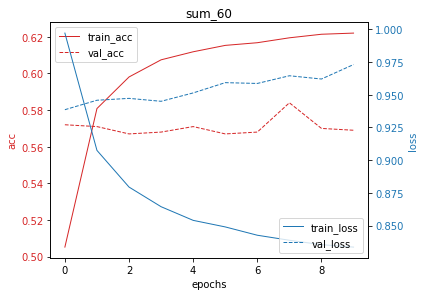

concat_30
Epoch 0:	Train loss: 0.9317941665649414	Train accuracy: 0.55252	            Valid loss: 0.8549829721450806	Valid accuracy: 0.612
Epoch 1:	Train loss: 0.8023896217346191	Train accuracy: 0.64544	            Valid loss: 0.8510581851005554	Valid accuracy: 0.62
Epoch 2:	Train loss: 0.7666254043579102	Train accuracy: 0.6653	            Valid loss: 0.8603338003158569	Valid accuracy: 0.627
Epoch 3:	Train loss: 0.7459501028060913	Train accuracy: 0.67565	            Valid loss: 0.8625161647796631	Valid accuracy: 0.632
Epoch 4:	Train loss: 0.7273465394973755	Train accuracy: 0.68606	            Valid loss: 0.8757347464561462	Valid accuracy: 0.62
Epoch 5:	Train loss: 0.7121732831001282	Train accuracy: 0.69455	            Valid loss: 0.897945761680603	Valid accuracy: 0.623
Epoch 6:	Train loss: 0.6982281804084778	Train accuracy: 0.70262	            Valid loss: 0.9017629027366638	Valid accuracy: 0.621
Epoch 7:	Train loss: 0.6877802610397339	Train accuracy: 0.70607	            Valid loss: 0.9

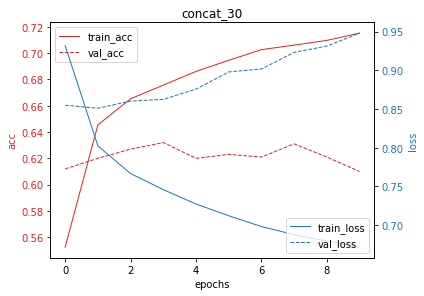

concat_40
Epoch 0:	Train loss: 0.9278291463851929	Train accuracy: 0.55406	            Valid loss: 0.8409069776535034	Valid accuracy: 0.626
Epoch 1:	Train loss: 0.8010637164115906	Train accuracy: 0.64839	            Valid loss: 0.8582707047462463	Valid accuracy: 0.626
Epoch 2:	Train loss: 0.7655382752418518	Train accuracy: 0.66717	            Valid loss: 0.8636307120323181	Valid accuracy: 0.617
Epoch 3:	Train loss: 0.7404835224151611	Train accuracy: 0.679	            Valid loss: 0.8821417689323425	Valid accuracy: 0.61
Epoch 4:	Train loss: 0.7216119766235352	Train accuracy: 0.68857	            Valid loss: 0.8911854028701782	Valid accuracy: 0.625
Epoch 5:	Train loss: 0.7048898935317993	Train accuracy: 0.69822	            Valid loss: 0.9030823111534119	Valid accuracy: 0.611
Epoch 6:	Train loss: 0.692206084728241	Train accuracy: 0.70458	            Valid loss: 0.923819899559021	Valid accuracy: 0.61
Epoch 7:	Train loss: 0.6823462843894958	Train accuracy: 0.70851	            Valid loss: 0.940

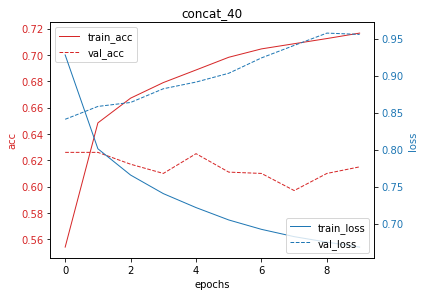

concat_50
Epoch 0:	Train loss: 0.9188737869262695	Train accuracy: 0.56362	            Valid loss: 0.8566859364509583	Valid accuracy: 0.628
Epoch 1:	Train loss: 0.799739420413971	Train accuracy: 0.64717	            Valid loss: 0.8523626923561096	Valid accuracy: 0.622
Epoch 2:	Train loss: 0.7633898258209229	Train accuracy: 0.66826	            Valid loss: 0.8660755157470703	Valid accuracy: 0.626
Epoch 3:	Train loss: 0.739075779914856	Train accuracy: 0.68044	            Valid loss: 0.87128084897995	Valid accuracy: 0.635
Epoch 4:	Train loss: 0.7185651659965515	Train accuracy: 0.69116	            Valid loss: 0.8934266567230225	Valid accuracy: 0.621
Epoch 5:	Train loss: 0.7041136026382446	Train accuracy: 0.6999	            Valid loss: 0.9051756858825684	Valid accuracy: 0.617
Epoch 6:	Train loss: 0.6915149092674255	Train accuracy: 0.70378	            Valid loss: 0.9224616289138794	Valid accuracy: 0.612
Epoch 7:	Train loss: 0.6822418570518494	Train accuracy: 0.70886	            Valid loss: 0.93

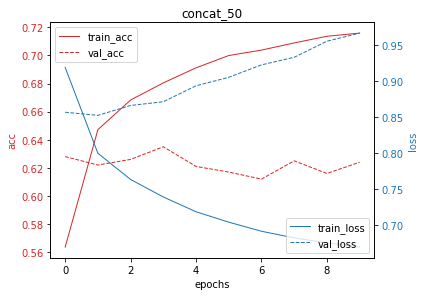

concat_60
Epoch 0:	Train loss: 0.914603590965271	Train accuracy: 0.56612	            Valid loss: 0.851164698600769	Valid accuracy: 0.621
Epoch 1:	Train loss: 0.7995160222053528	Train accuracy: 0.64837	            Valid loss: 0.8509442210197449	Valid accuracy: 0.633
Epoch 2:	Train loss: 0.7614226341247559	Train accuracy: 0.66967	            Valid loss: 0.8619576692581177	Valid accuracy: 0.622
Epoch 3:	Train loss: 0.7377907633781433	Train accuracy: 0.68151	            Valid loss: 0.8771926164627075	Valid accuracy: 0.617
Epoch 4:	Train loss: 0.7186271548271179	Train accuracy: 0.6897	            Valid loss: 0.8976247310638428	Valid accuracy: 0.609
Epoch 5:	Train loss: 0.7034860849380493	Train accuracy: 0.69862	            Valid loss: 0.9053115844726562	Valid accuracy: 0.607
Epoch 6:	Train loss: 0.6926485896110535	Train accuracy: 0.70326	            Valid loss: 0.9149912595748901	Valid accuracy: 0.619
Epoch 7:	Train loss: 0.6832311153411865	Train accuracy: 0.70788	            Valid loss: 0.

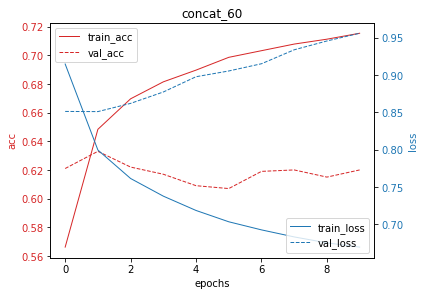

In [36]:
import math

embed_dims = [30, 40, 50 , 60]
reduces = ["hadamard", "sum", "concat"]

params = {
    "learning_rate" : 0.02,
    "num_epochs" : 10
}

best_model = None
best_reduce = None
best_embed = None
best_val_acc = -1


models = dict()

for reduce in reduces:
    for embed_dim in embed_dims:
        params["emb_dim"] = embed_dim
        params["reduce"] = reduce
        model, per_epoch_metrics, title = train_wrapper(params)
        
        models[f"{reduce}_{embed_dim}"] = model
        
        if per_epoch_metrics["val_accs"][-1] > best_val_acc:
            best_val_acc = per_epoch_metrics["val_accs"][-1]
            best_model = model
            best_reduce = reduce
            best_embed = embed_dim
 
        plot_over_training(per_epoch_metrics, title)


**Written 2:** (4 pts)   
Take your best model based on validation performace and report its validation accuracy:

In [39]:
print(f"Best reduce: {best_reduce}")
print(f"Best embedding dimension: {best_embed}")
print(f"Best validation accuracy: {best_val_acc}")

Best reduce: concat
Best embedding dimension: 50
Best validation accuracy: 0.624


**Written 3:** (4 pts)

Highlight 3 correct and 3 incorrect predictions in this validation set. Describe why the model might have gotten the 3 incorrect predictions wrong.

In [40]:
def eval(model, val_loader, num_samples):
    
    correct_samples = list()
    incorrect_samples = list()
    
    with torch.no_grad():

        for hypo_idx, hypo_idx_len, prem_idx, prem_idx_len, label in val_loader:

            output = model(hypo_idx, hypo_idx_len, prem_idx, prem_idx_len)

            # batch level info
            output_categories = output.argmax(dim=1)
            true_indices = (label == output_categories).nonzero().squeeze(dim=1)
            false_indices = (label != output_categories).nonzero().squeeze(dim=1)
            
            def extract(indices, samples):
                for index in indices[:num_samples - len(samples)]:
                    sample = (hypo_idx[index],
                              hypo_idx_len[index],
                              prem_idx[index],
                              prem_idx_len[index],
                              label[index],
                              output_categories[index])
                    samples.append(sample)
            
            extract(true_indices, correct_samples)
            extract(false_indices, incorrect_samples)
    
    return correct_samples, incorrect_samples

In [41]:
reduce = "concat"
correct_samples, incorrect_samples = eval(best_model, val_loader, 3)

In [42]:
def decode_sample(sample: torch.tensor, length: int):
    sample = sample[:length]
    return [id2token[id] for id in sample.tolist()]

In [43]:
def print_samples(samples: List):

    for sample in samples:
        hypo = sample[0]
        hypo_len = sample[1].item()
        prem = sample[2]
        prem_len = sample[3].item()
        label = sample[4].item()
        predicted = sample[5].item()
        print(f"\nActual: {label}, Predicted: {predicted}\n")
        print(decode_sample(hypo, hypo_len))
        print(decode_sample(prem, prem_len))



print("\n---------- CORRECT SAMPLES --------------\n")
print_samples(correct_samples)

print("\n---------- INCORRECT SAMPLES --------------\n")
print_samples(incorrect_samples)


---------- CORRECT SAMPLES --------------


Actual: 0, Predicted: 0

['children', 'are', 'trying', 'to', 'learn', 'how', 'to', 'swim', 'with', 'their', 'parents', 'in', 'a', 'large', 'pool', 'with', 'a', 'red', 'staircase']
['children', 'and', 'adults', 'swim', 'in', 'large', 'pool', 'with', 'red', 'staircase']

Actual: 2, Predicted: 2

['a', 'dog', 'is', 'tearing', 'at', 'the', '<unk>', 'throat']
['a', 'dog', 'chasing', 'a', 'deer', 'in', 'a', 'field', 'with', 'yellow', 'flowers']

Actual: 0, Predicted: 0

['rival', 'college', 'football', 'players', 'are', 'playing', 'a', 'football', 'game']
['three', 'oklahoma', 'sooners', 'playing', 'football', 'against', 'another', 'team', 'one', 'of', 'the', 'sooners', 'with', 'the', 'ball', 'in', 'their', 'possession']

---------- INCORRECT SAMPLES --------------


Actual: 0, Predicted: 1

['the', 'birds', 'fly', 'away', 'in', 'surprise']
['a', 'flock', 'of', 'birds', '<unk>', 'and', 'in', 'flight', 'in', 'front', 'of', 'a', 'wall', 'that', 'has

0 - neutral
1- entail
2- contradict



**Sentence 1**

The model might have assumed that "flying in front of a wall that has a mural of three women" would lead to a surprise for the birds. As a result the model predicted Entailment. However, this may not be true and can be unrelated. 

**Sentence 2**

It is possible that the model assumed "man" and "balding man" to different entity altogether. As a result, it might have predicted a contradiction, instead of an entailment.  

**Sentence 3**

The model may not have encompased the color of the hat of the lady. Given that in both the sentences the lady has a hat, the sentence might have predicted an entailment, however both scenarios are different.

In [44]:
!pip install torchsummary

from torchsummary import summary

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [45]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for name, model in models.items():
    params = count_parameters(model)
    print(f"Model: {name}, Parameters: {params}")

Model: hadamard_30, Parameters: 300153
Model: hadamard_40, Parameters: 400203
Model: hadamard_50, Parameters: 500253
Model: hadamard_60, Parameters: 600303
Model: sum_30, Parameters: 300153
Model: sum_40, Parameters: 400203
Model: sum_50, Parameters: 500253
Model: sum_60, Parameters: 600303
Model: concat_30, Parameters: 300243
Model: concat_40, Parameters: 400323
Model: concat_50, Parameters: 500403
Model: concat_60, Parameters: 600483
